# Flow in a nano-porous material

In this notebook we'll explore flow induced in a nano-porous material. To do this we introduce a force $\mathbf{F}_x$ acting on each particle $i$ in the nano-porous material.
In the case of a gravitational field, we can formulate Darcy's law for flow as
\begin{align}
    \mathbf{U} = \frac{k}{\mu}\left( \nabla P - \rho \mathbf{a} \right).
\end{align}
Here $\mathbf{U}$ is the _Darcy velocity_, $k$ the permeabillity, $\mu$ the fluid viscosity, $P$ the externally applied pressure, $\rho$ the density and $\mathbf{a}$ the acceleration from the applied force. In our case $\nabla P = 0$ as we have no externally applied pressure. Looking at Newton's second law for a single particle we have
\begin{align}
    \mathbf{F}_x = m_i \mathbf{a}_i.
\end{align}
For all particles of the same mass with the same applied force this yields the total applied for to the system
\begin{align}
    N\mathbf{F}_x = N m \mathbf{a},
\end{align}
where $N$ is the number of particles. Dividng by the volume of the system we find
\begin{gather}
    \frac{N}{V}\mathbf{F}_x = \frac{N m}{V} \mathbf{a}
    \implies
    n \mathbf{F}_x = \rho \mathbf{a},
\end{gather}
where $n$ is the number density and $\rho$ the density of the system. Thus we see that we can replace $\rho \mathbf{a}$ in Darcy's law with $n\mathbf{F}_x$ and we write
\begin{align}
    \mathbf{U} = \frac{k}{\mu}\left( \nabla P - n \mathbf{F}_x \right).
\end{align}

In [15]:
import os
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from read_lammps_dump import read_dump
from read_lammps_log import read_log, get_temp_lognames

sns.set(color_codes=True)

In [14]:
%%writefile scripts/flow_profile.in

# 3d Lennard-Jones gas
units lj
dimension 3
# Periodic boundiaries
boundary p p p
atom_style atomic

variable seed equal 87287
variable sigma equal 3.405
variable b equal 5.72
variable reduced_density equal 4/((${b}/${sigma})^3)
variable temperature equal 1.5
variable num_box equal 20
variable radius_min equal 20/${sigma}
variable radius_max equal 30/${sigma}

# Set fcc lattice with specified density
lattice fcc ${reduced_density}
region simbox block 0 ${num_box} 0 ${num_box} 0 ${num_box}
create_box 2 simbox
create_atoms 1 box

variable box_len equal lx

mass * 1.0
velocity all create ${temperature} ${seed}

pair_style lj/cut 3.0
pair_coeff * * 1.0 1.0

fix 1 all nvt temp ${temperature} ${temperature} 0.5

thermo 100
run 1000

# Use a radius of 2 nm (equal to 20 Å)
variable radius equal 20/${sigma}
variable centre_x equal lx/2
variable centre_y equal ly/2
variable centre_z equal lz/2
region cylinder_reg cylinder x ${centre_y} ${centre_z} ${radius} EDGE EDGE units box

# Delete half of the atoms in the region
delete_atoms porosity cylinder_reg 0.5 ${seed}

group pore_group region cylinder_reg
set group pore_group type 2

# Create another group from all the remaining atoms except for the ones in the cylinder
group frozen subtract all pore_group
# Set the velocity of the atoms outside the cylinder to zero
velocity frozen set 0 0 0
# Avoid integrating all the particles
unfix 1

# Run pore_group using NVE
fix 1 pore_group nve

dump 1 all custom 10 dat/flow_profile.lammpstrj id type x y z vx vy vz

# Compute the porosity
variable porosity equal count(pore_group)/count(all)
print ${porosity} file dat/flow_profile_porosity.dat

reset_timestep 0
compute pore_temp pore_group temp
compute msd pore_group msd
variable time equal dt*step

thermo_style custom step v_time c_pore_temp etotal press c_msd[4]

fix force pore_group addforce 0.1 0.0 0.0

thermo 10
log dat/flow_profile.log

run 2000

Overwriting scripts/flow_profile.in


In [12]:
!export OMP_NUM_THREADS=4 && mpirun -np 4 lmp -in scripts/flow_profile.in

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1.67988 1.67988 1.67988
Created orthogonal box = (0 0 0) to (33.5977 33.5977 33.5977)
  1 by 2 by 2 MPI processor grid
Created 32000 atoms
  Time spent = 0.000936326 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 21 21 21
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 11.78 | 11.78 | 11.78 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0          1.5   -6.9322187            0    -4.682289   -5.2444747 
     100   0.83086252   -5.837479

     680          3.4      3.97255   -4.5722393     3.541191    23.376589 
     690         3.45    4.0052179   -4.5671354    3.5525372    24.388756 
     700          3.5    4.1409667   -4.5620386    3.5377442    25.435826 
     710         3.55    4.1350852   -4.5568611     3.564173    26.524506 
     720          3.6    4.2289219   -4.5516577     3.561721    27.644657 
     730         3.65    4.2729326   -4.5463693    3.5741881    28.792112 
     740          3.7    4.3117577   -4.5410201    3.5867274    29.971253 
     750         3.75     4.413177   -4.5356307    3.5786625    31.177907 
     760          3.8    4.4460504   -4.5301691    3.5902842    32.420125 
     770         3.85    4.5246194   -4.5246956    3.5913368    33.703625 
     780          3.9    4.6414188   -4.5191244    3.5826175    35.032894 
     790         3.95    4.6870589    -4.513518     3.594336    36.399381 
     800            4    4.7286654   -4.5078875    3.6066993    37.796534 
     810         4.05    

    1780          8.9    12.606793   -3.8211243    4.2659459    407.98863 
    1790         8.95    12.669929   -3.8134716    4.2739709    414.06308 
    1800            9    12.930027   -3.8064286    4.2304414    420.18528 
    1810         9.05    12.909803   -3.7987114    4.2594595     426.5081 
    1820          9.1    13.036669   -3.7911148    4.2559203     432.9299 
    1830         9.15    13.100235   -3.7836055    4.2758046    439.41459 
    1840          9.2    13.146261   -3.7758944    4.3019927    446.04417 
    1850         9.25    13.188015   -3.7683086    4.3271723    452.70219 
    1860          9.3    13.345279   -3.7609373     4.319715     459.2758 
    1870         9.35    13.434558   -3.7531937    4.3194898    465.91237 
    1880          9.4     13.44966   -3.7455567    4.3435133    472.63881 
    1890         9.45    13.693175   -3.7376995    4.3138342    479.28206 
    1900          9.5    13.658181   -3.7298423    4.3542712    485.91225 
    1910         9.55    

In [16]:
df, num_atoms, bounds = read_dump("dat/flow_profile.lammpstrj")

In [33]:
centre_bounds = [np.sum(bound) / 2 for bound in bounds]

In [18]:
df.head()

,id,type,x,y,z,vx,vy,vz,timestep
0,1,1,1.317050,0.539350,1.321310,0.0,0.0,0.0,0
1,2,1,0.730629,0.913395,0.438076,0.0,0.0,0.0,0
2,3,1,1.489180,0.110520,0.252968,0.0,0.0,0.0,0
3,4,1,2.822600,0.398555,0.965105,0.0,0.0,0.0,0
4,5,1,2.492060,1.469520,0.833761,0.0,0.0,0.0,0


In [21]:
df_flowing = df[df.type == 2]

In [22]:
df_flowing.head()

,id,type,x,y,z,vx,vy,vz,timestep
5456,5457,2,0.047327,14.4051,11.5221,0.261905,1.547730,-0.142932,0
5461,5462,2,4.995970,14.3578,11.5652,-0.814679,0.088776,2.151870,0
5471,5472,2,7.869410,14.3234,11.7257,-0.107854,-1.664720,-0.679219,0
5476,5477,2,9.216250,14.1895,11.6376,2.152910,-1.234740,-0.632470,0
5490,5491,2,32.132100,16.2043,16.1695,-1.195920,-0.712419,-1.389600,0


In [34]:
df_flowing.x -= centre_bounds[0]
df_flowing.y -= centre_bounds[1]
df_flowing.z -= centre_bounds[2]

/home/schoyen/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [49]:
df_flowing.loc["r"] = np.sqrt(df_flowing["y"] ** 2 + df_flowing["z"] ** 2)

/home/schoyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
df_flowing.head()

,id,type,x,y,z,vx,vy,vz,timestep,r
5456,5457.0,2.0,-16.751499,-2.393725,-5.276725,0.261905,1.547730,-0.142932,0.0,5.794286
5461,5462.0,2.0,-11.802855,-2.441025,-5.233625,-0.814679,0.088776,2.151870,0.0,5.774897
5471,5472.0,2.0,-8.929415,-2.475425,-5.073125,-0.107854,-1.664720,-0.679219,0.0,5.644850
5476,5477.0,2.0,-7.582575,-2.609325,-5.161225,2.152910,-1.234740,-0.632470,0.0,5.783323
5490,5491.0,2.0,15.333275,-0.594525,-0.629325,-1.195920,-0.712419,-1.389600,0.0,0.865743


In [43]:
r = df_flowing[df_flowing.timestep == np.max(df_flowing.timestep)].r

hist, bins = np.histogram(
    np.abs(df_flowing[df_flowing.timestep == np.max(df_flowing.timestep)].vx),
    np.linspace(0, np.max(r), 101)
)

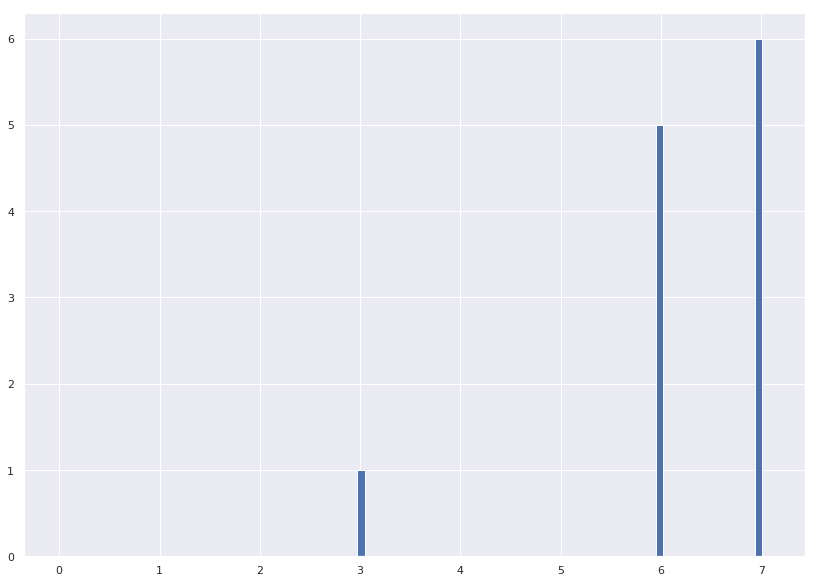

In [47]:
fig = plt.figure(figsize=(14, 10))

plt.hist(hist, bins)
plt.show()

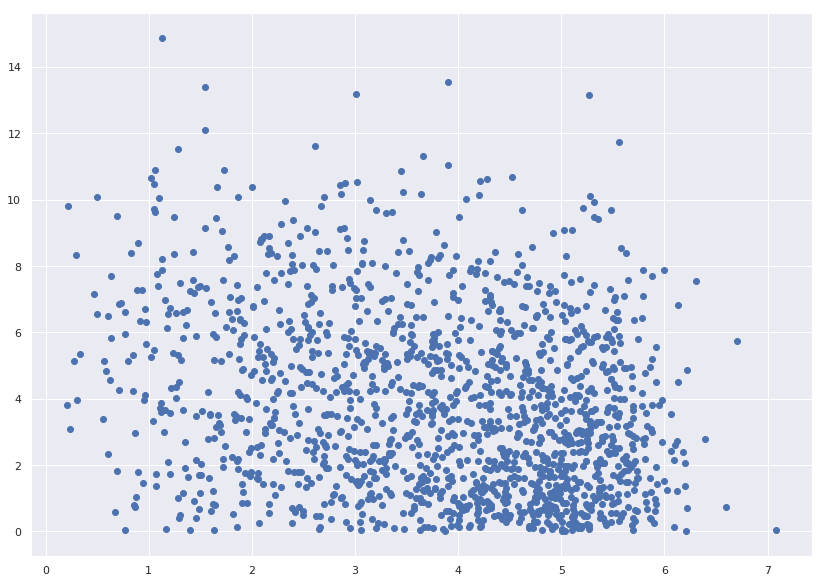

In [40]:
fig = plt.figure(figsize=(14, 10))

plt.scatter(
    df_flowing[df_flowing.timestep == np.max(df_flowing.timestep)].r,
    np.abs(df_flowing[df_flowing.timestep == np.max(df_flowing.timestep)].vx)
)
plt.show()